<a href="https://colab.research.google.com/github/arifpras/ExpectedDemand/blob/main/20240625_podem01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<div class="markdown-google-sans">

  <h1> Predicting Demand in the Primary Market: Pycaret</h1>
</div>

<div class="markdown-google-sans">

## <strong> Data Preparation </strong>
</div>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Libraries

In [2]:
%%capture

# !pip install -U scikit-learn==0.24.2
# !pip install -U imbalanced-learn

# %pip install openpyxl
# %pip install shap
# %pip install pycaret

!pip show pycaret || pip install pycaret

In [3]:
# Subsequent cells can use the installed library
import pycaret
pycaret.__version__

'3.3.2'

In [4]:
from pycaret.regression import *

import numpy as np
import pandas as pd
import openpyxl as xl
import matplotlib.pyplot as plt
import seaborn as sns

## Database

### Load

In [5]:
df_train00 = pd.read_excel('/content/drive/MyDrive/00database/db_monthfrac.xlsx', sheet_name='database')
df_train00['incoming_bid'] = df_train00['incoming_bid'].astype(float)
df_train00['issuance_date'] = pd.to_datetime(df_train00['issuance_date'], format='%Y-%m-%d')

df_train00.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1967 entries, 0 to 1966
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   issued_series     1967 non-null   object        
 1   issuance_date     1967 non-null   datetime64[ns]
 2   issuance_year     1967 non-null   int64         
 3   issuance_week     1967 non-null   int64         
 4   monthfrac         1967 non-null   int64         
 5   eid_weeks         1967 non-null   int64         
 6   srbi_issuance     1967 non-null   int64         
 7   vix_indicator     1967 non-null   int64         
 8   bi_covid          1967 non-null   int64         
 9   gso_issuance      1967 non-null   int64         
 10  investment_grade  1967 non-null   int64         
 11  incoming_bid      1967 non-null   float64       
dtypes: datetime64[ns](1), float64(1), int64(9), object(1)
memory usage: 184.5+ KB


In [6]:
df_train00['issued_series'].value_counts()

issued_series
sun10    302
sun20    297
spn12    282
sun15    282
sun05    276
spn03    248
sun30    180
spn09     76
sun07     11
sun08     10
sun04      1
vr04       1
sun02      1
Name: count, dtype: int64

In [7]:
df_train00.describe()

,issuance_date,issuance_year,issuance_week,monthfrac,eid_weeks,srbi_issuance,vix_indicator,bi_covid,gso_issuance,investment_grade,incoming_bid
count,1967,1967.000000,1967.000000,1967.000000,1967.000000,1967.000000,1967.000000,1967.000000,1967.000000,1967.000000,1.967000e+03
mean,2017-11-01 01:57:07.961362432,2017.389934,24.246568,124.595323,0.080834,0.057956,0.079309,0.239959,0.021861,0.865277,6.295412e+06
min,2009-01-13 00:00:00,2009.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00
25%,2014-03-04 00:00:00,2014.000000,12.000000,12.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2.410250e+06
50%,2018-08-14 00:00:00,2018.000000,24.000000,119.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,4.415000e+06
75%,2021-07-06 00:00:00,2021.000000,36.000000,189.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,8.014000e+06
max,2024-06-11 00:00:00,2024.000000,51.000000,367.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,4.516780e+07
std,NaN,4.388086,14.017273,108.715622,0.272649,0.233720,0.270289,0.427167,0.146266,0.341514,5.909344e+06


<Axes: xlabel='incoming_bid', ylabel='issuance_week'>

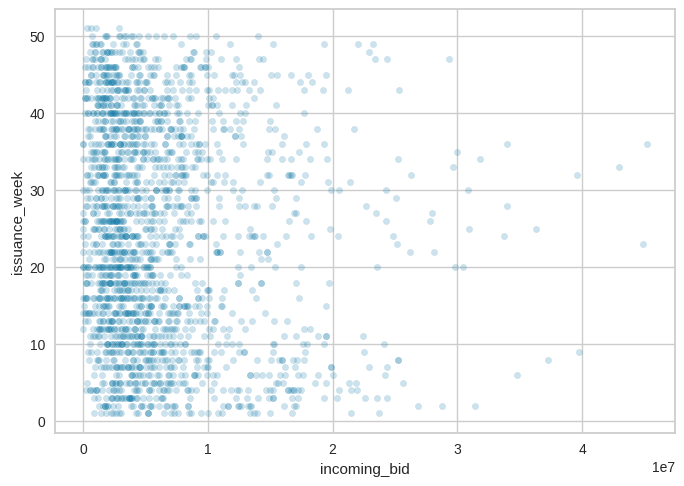

In [8]:
df_train00.plot(kind = 'scatter', x = 'incoming_bid', y = 'issuance_week', alpha = 0.2)

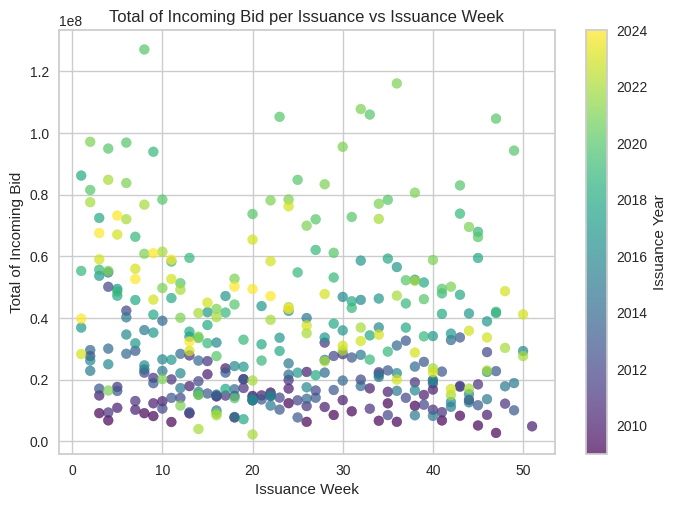

In [9]:
# import matplotlib.pyplot as plt

grouped_series01 = df_train00.groupby(['issuance_date']).agg({
    'incoming_bid': 'sum',
    'issuance_week': 'mean',
    'issuance_year': 'mean'
}).reset_index()

# Convert 'issuance_year' to integer
grouped_series01['issuance_year'] = grouped_series01['issuance_year'].astype(int)


# Scatter plot
# plt.figure(figsize=(10, 6))
plt.scatter(grouped_series01['issuance_week'], grouped_series01['incoming_bid'], s=50, c=grouped_series01['issuance_year'], alpha=0.7, cmap='viridis')
plt.title('Total of Incoming Bid per Issuance vs Issuance Week')
plt.xlabel('Issuance Week')
plt.ylabel('Total of Incoming Bid')
plt.colorbar(label='Issuance Year')
plt.grid(True)
plt.show()

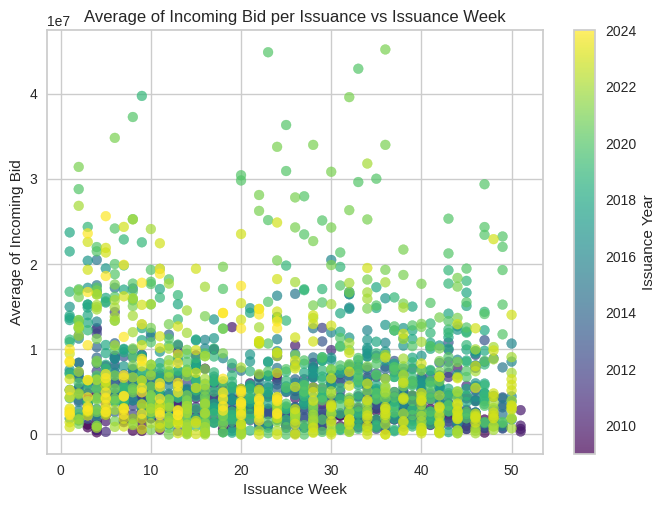

In [10]:
# import matplotlib.pyplot as plt

grouped_series02 = df_train00.groupby(['issuance_date', 'issued_series']).agg({
    'incoming_bid': 'mean', #average
    'issuance_week': 'mean',
    'issuance_year': 'mean'
}).reset_index()

# Convert 'issuance_year' to integer
grouped_series02['issuance_year'] = grouped_series02['issuance_year'].astype(int)


# Scatter plot
# plt.figure(figsize=(10, 6))
plt.scatter(grouped_series02['issuance_week'], grouped_series02['incoming_bid'], s=50, c=grouped_series02['issuance_year'], alpha=0.7, cmap='viridis')
plt.title('Average of Incoming Bid per Issuance vs Issuance Week')
plt.xlabel('Issuance Week')
plt.ylabel('Average of Incoming Bid')
plt.colorbar(label='Issuance Year')
plt.grid(True)
plt.show()

In [11]:
# sns.catplot(x='issued_series', y='incoming_bid', data=grouped_series02,
#                 kind='boxen', col='issuance_year', col_wrap=2)

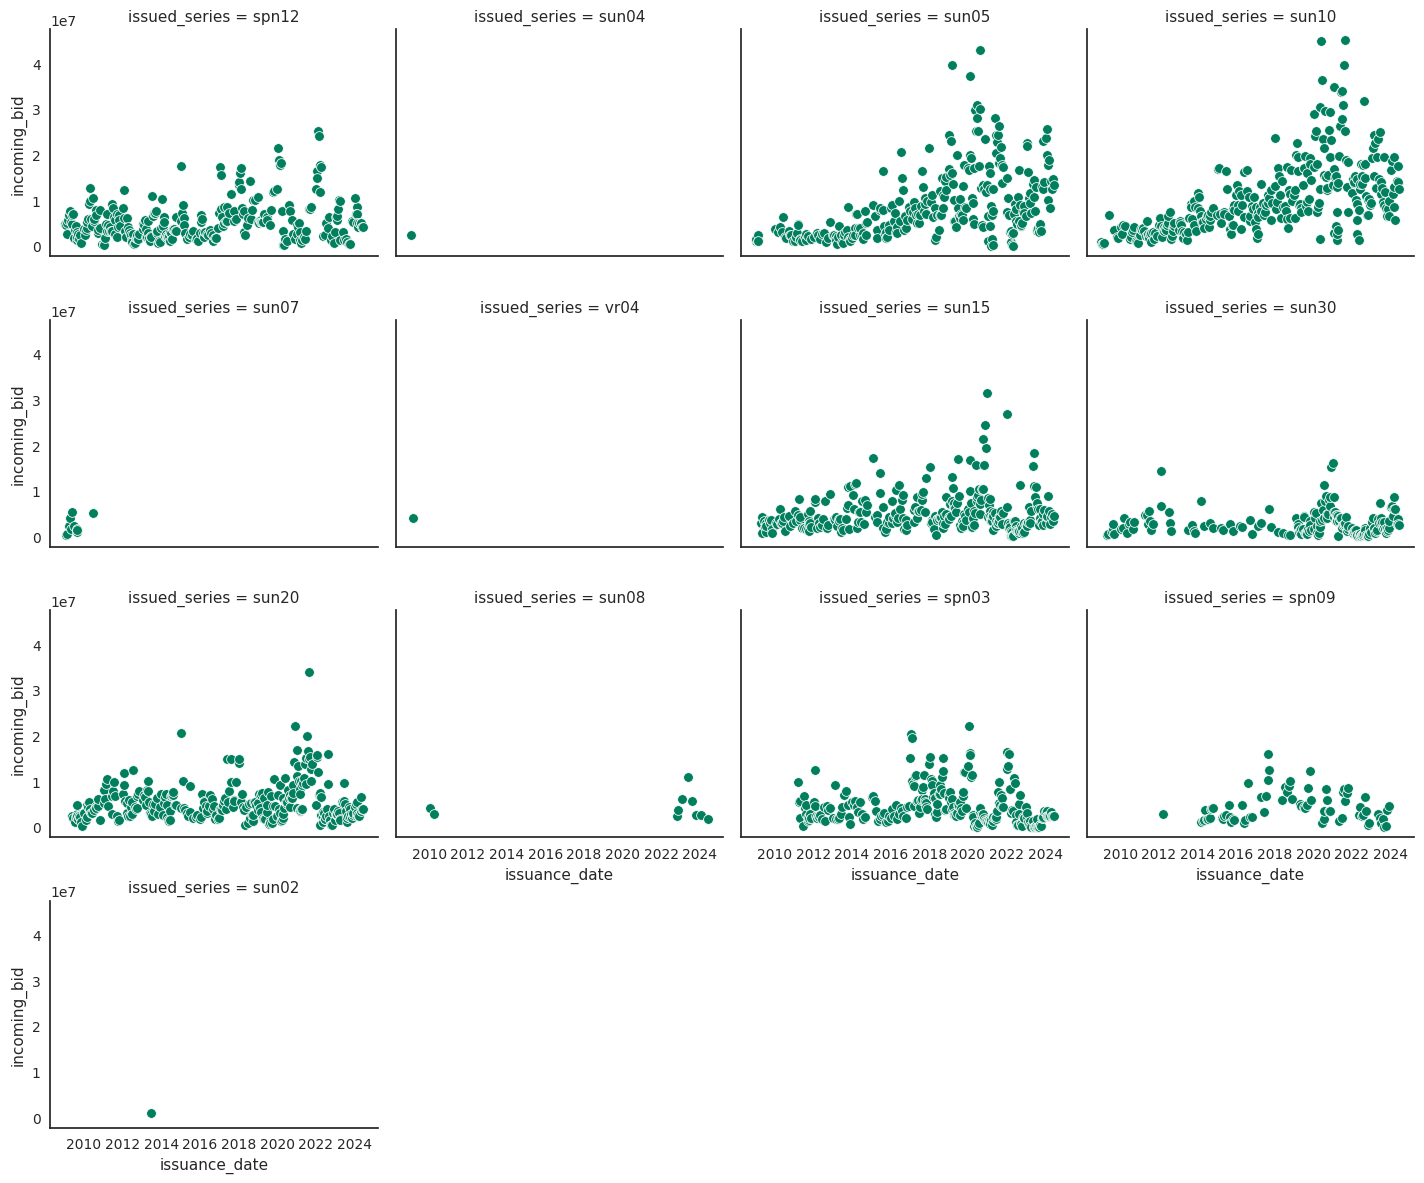

In [12]:
# import seaborn as sns
# import matplotlib.pyplot as plt

sns.set_style("white")

# Create a FacetGrid and use map to create subplots based on 'FacetVar'
ch01 = sns.FacetGrid(df_train00, col='issued_series', col_wrap=4, height=3, aspect=1.2)
ch01.map(sns.scatterplot, 'issuance_date', 'incoming_bid', color='#007e5d')

# Show the plot
# plt.show()


In [ ]:
# corr_matrix = df_train00.corr()
# corr_matrix['incoming_bid'].sort_values(ascending=False)

In [13]:
df_train01 = df_train00[~df_train00['issued_series'].isin(['sun04', 'sun02', 'vr04', 'spn09', 'sun07'])]

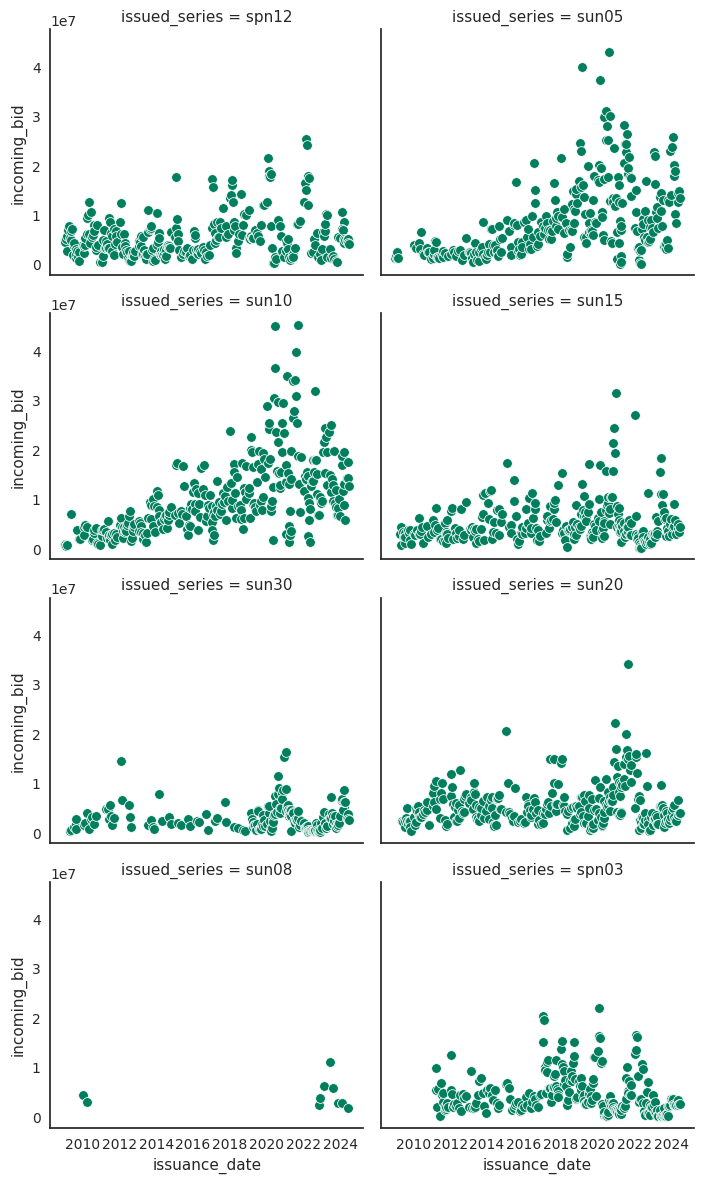

In [14]:
# import seaborn as sns
# import matplotlib.pyplot as plt

sns.set_style("white")

# Create a FacetGrid and use map to create subplots based on 'FacetVar'
ch02 = sns.FacetGrid(df_train01, col='issued_series', col_wrap=2, height=3, aspect=1.2)
ch02.map(sns.scatterplot, 'issuance_date', 'incoming_bid', color='#007e5d')

# Show the plot
# plt.show()


In [15]:
# Get the order of categories
issd_series = df_train01['issued_series'].unique()

# Sort the order
issd_series.sort()

# Create a boxplot with sorted order
# sns.boxplot(x='issued_series', y='incoming_bid', data=df_train01,
#             order=issd_series, hue='issuance_year')

# sns.boxplot(x='issued_series', y='incoming_bid', data=df_train01,
#             order=issd_series)
# plt.show()

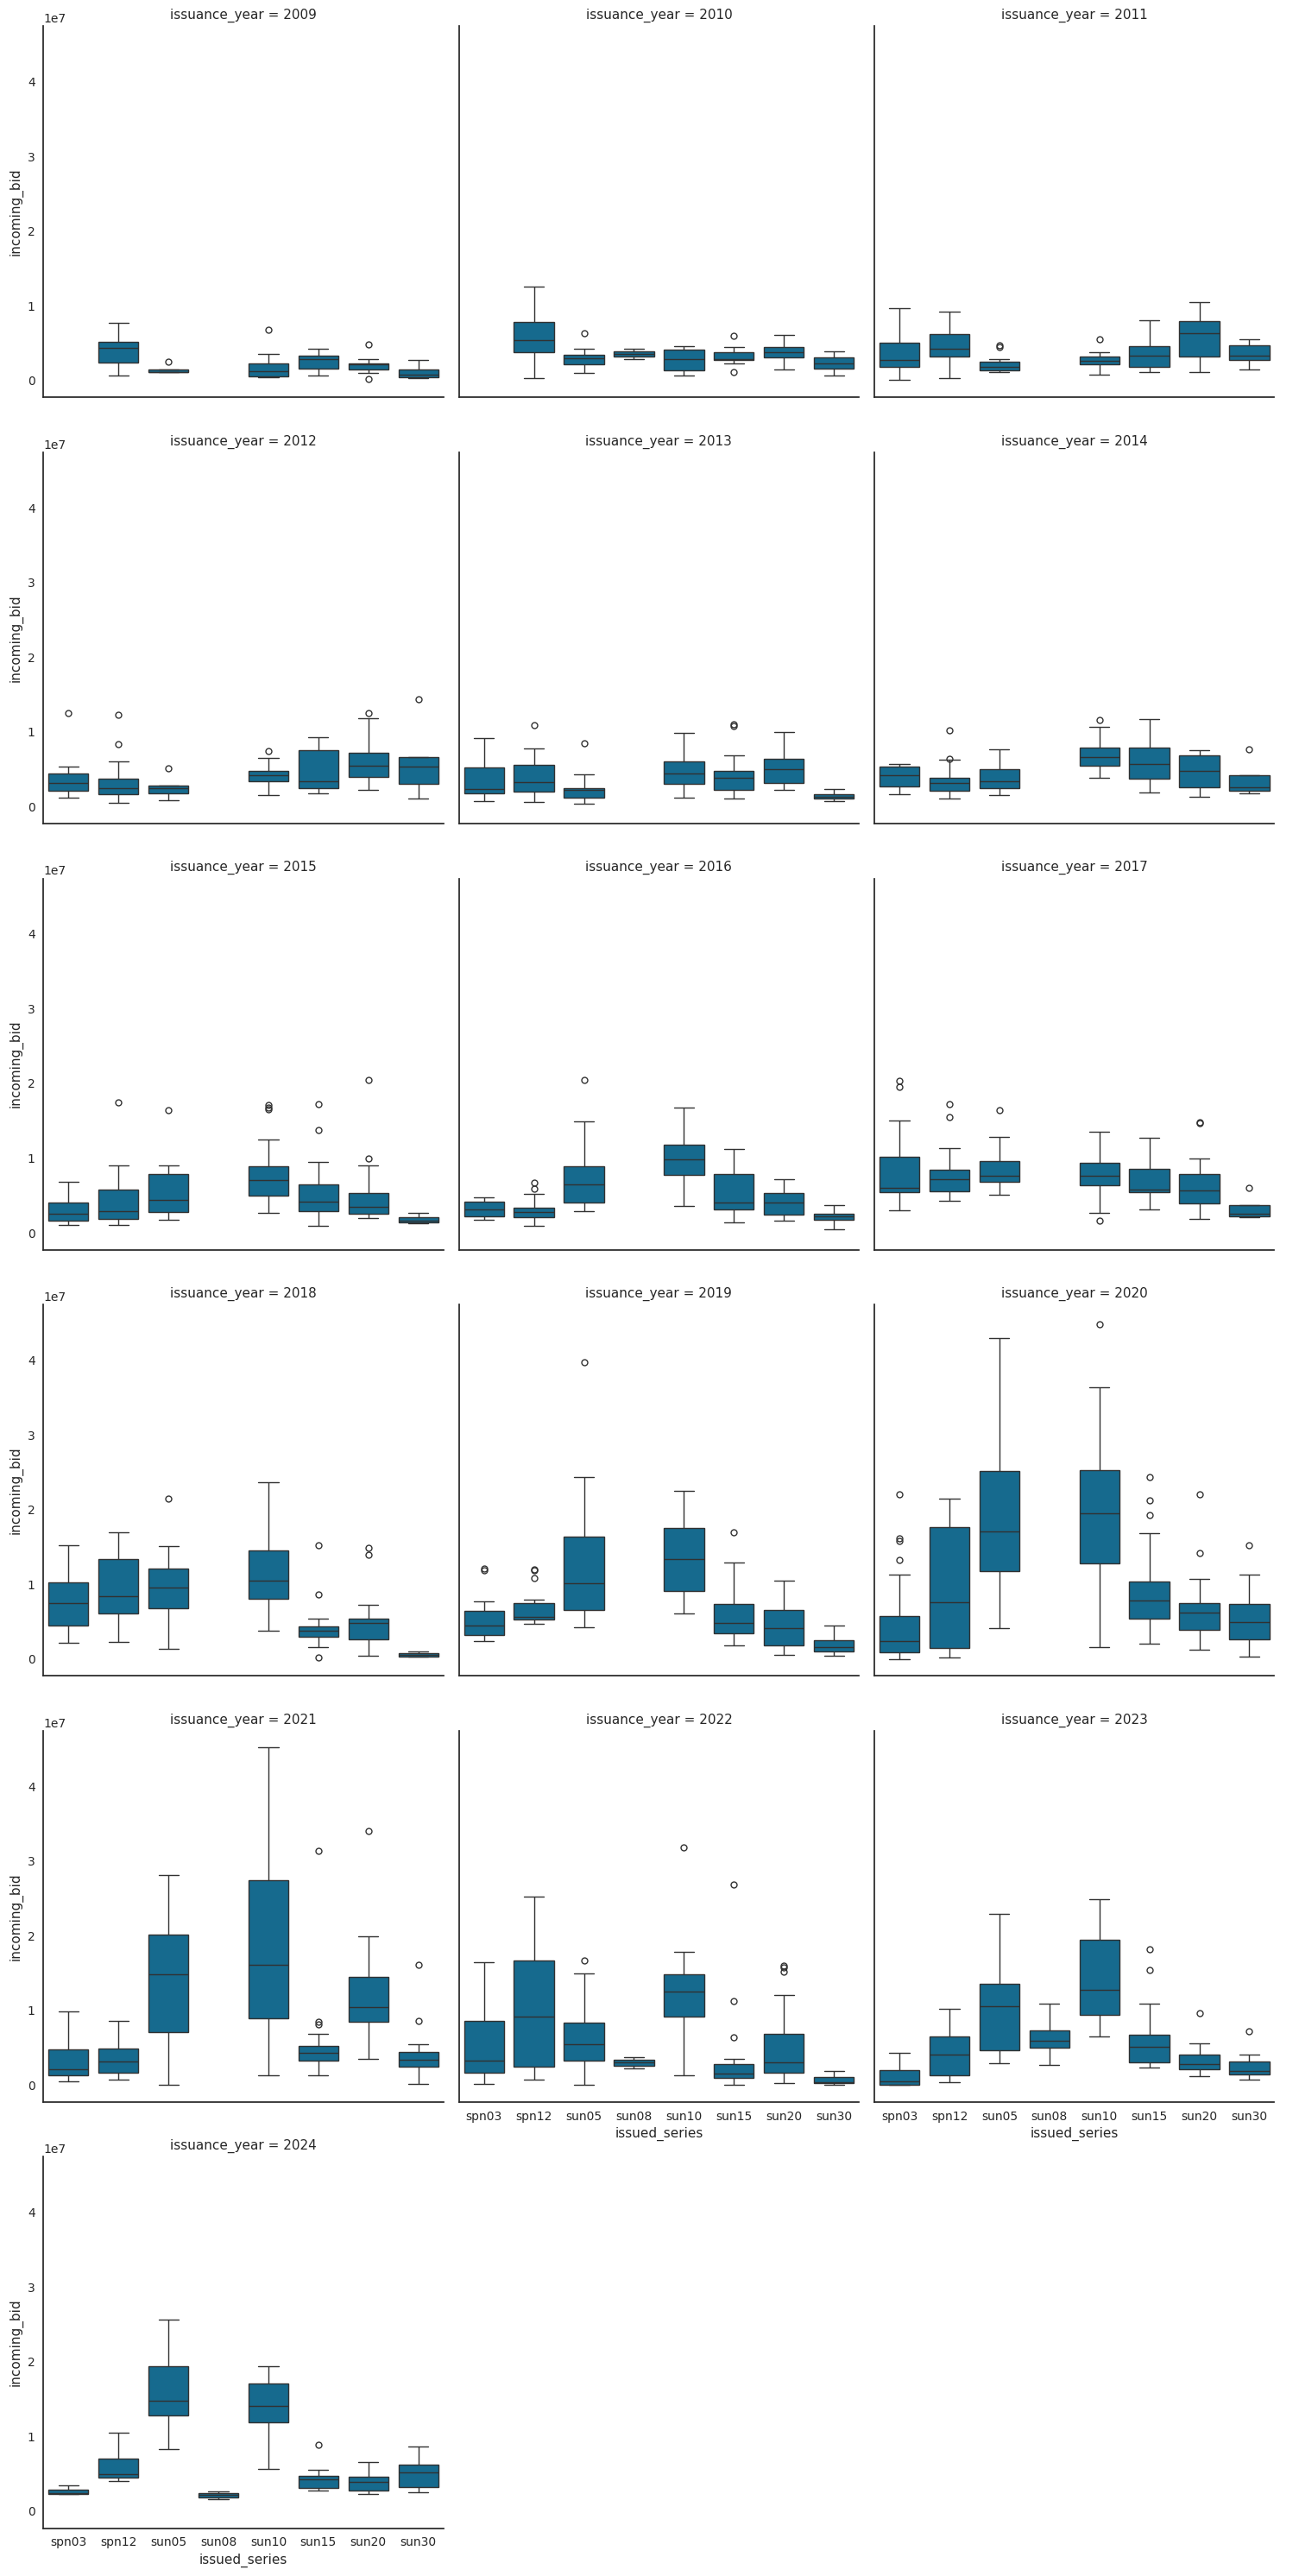

In [16]:
sns.catplot(x='issued_series', y='incoming_bid', data=df_train01,
                order=issd_series, kind='box', col='issuance_year', col_wrap=3)

### Split: Biased

In [ ]:
# df_train02 = df_train01.sample(frac=0.9, random_state=786)
# df_unseen01 = df_train01.drop(df_train02.index)

# df_train02.reset_index(drop=True, inplace=True)
# df_unseen01.reset_index(drop=True, inplace=True)

# print('Data for Modeling: ' + str(df_train02.shape))
# print('Unseen Data For Predictions: ' + str(df_unseen01.shape))

In [ ]:
# print("Train: \n{} \n\nTest: \n{}".format(df_train02['issued_series'].value_counts(), df_unseen01['issued_series'].value_counts()))

### Split: Stratified

In [17]:
from sklearn.model_selection import StratifiedShuffleSplit

# Assuming df is your DataFrame and 'target_column' is the target variable
split = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=42)

for train_index, test_index in split.split(df_train01, df_train01['issued_series']):
    # Explicitly reset the index
    df_train02 = df_train01.iloc[train_index]
    df_unseen01 = df_train01.iloc[test_index]

# Explicitly reset the index for df_train02 and df_test01
# df_train02 = df_train02.reset_index(drop=True)
# df_unseen01 = df_unseen01.reset_index(drop=True)

# Display the shapes of the resulting sets (optional)
print("Train set shape:", df_train02.shape)
print("Test set shape:", df_unseen01.shape)

Train set shape: (1689, 12)
Test set shape: (188, 12)


In [18]:
print("Train: \n{} \n\nTest: \n{}".format(df_train02['issued_series'].value_counts(), df_unseen01['issued_series'].value_counts()))

Train: 
issued_series
sun10    272
sun20    267
spn12    254
sun15    254
sun05    248
spn03    223
sun30    162
sun08      9
Name: count, dtype: int64 

Test: 
issued_series
sun10    30
sun20    30
sun15    28
sun05    28
spn12    28
spn03    25
sun30    18
sun08     1
Name: count, dtype: int64


In [19]:
# Identifying duplicates
duplicates = df_train02[df_train02.index.duplicated()]
print("Rows with duplicate indices:")
print(duplicates)


Rows with duplicate indices:
Empty DataFrame
Columns: [issued_series, issuance_date, issuance_year, issuance_week, monthfrac, eid_weeks, srbi_issuance, vix_indicator, bi_covid, gso_issuance, investment_grade, incoming_bid]
Index: []


In [20]:
# Identifying duplicates
duplicates = df_unseen01[df_unseen01.index.duplicated()]
print("Rows with duplicate indices:")
print(duplicates)

Rows with duplicate indices:
Empty DataFrame
Columns: [issued_series, issuance_date, issuance_year, issuance_week, monthfrac, eid_weeks, srbi_issuance, vix_indicator, bi_covid, gso_issuance, investment_grade, incoming_bid]
Index: []


# Methods

## Setup

In [21]:
session01 = setup(data=df_train02, target='incoming_bid', session_id=123,
                  test_data=df_unseen01,
                  categorical_features=['issued_series'],
                  ignore_features = ['issuance_date'])

,Description,Value
0,Session id,123
1,Target,incoming_bid
2,Target type,Regression
3,Original data shape,"(1877, 12)"
4,Transformed data shape,"(1877, 18)"
5,Transformed train set shape,"(1689, 18)"
6,Transformed test set shape,"(188, 18)"
7,Ignore features,1
8,Numeric features,9
9,Categorical features,1


## Compare Models

In [22]:
best01 = compare_models(sort = 'rmse')

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
et,Extra Trees Regressor,2326631.4390,12457886957828.3711,3502626.9867,0.6457,1.1064,0.8013,0.4460
xgboost,Extreme Gradient Boosting,2397335.6500,12760187037286.4004,3551759.6750,0.6312,1.2009,0.9068,0.2640
rf,Random Forest Regressor,2418356.9015,12892182989582.1641,3565604.8077,0.6352,1.1947,1.0122,0.7640
lightgbm,Light Gradient Boosting Machine,2442088.8958,12992509788179.5957,3572554.3451,0.6338,1.1910,1.0013,0.5260
gbr,Gradient Boosting Regressor,2903276.7328,17648155845420.4102,4175135.1677,0.5030,1.3025,1.1606,0.3190
knn,K Neighbors Regressor,3120462.0500,20284208630988.8008,4476566.5500,0.4290,1.3405,1.7597,0.0720
dt,Decision Tree Regressor,2966914.8327,21010058877981.7891,4560868.6784,0.3789,1.2819,0.9408,0.1100
llar,Lasso Least Angle Regression,3672664.2083,26158880875556.2695,5093403.0625,0.2601,1.4804,2.3692,0.0760
lasso,Lasso Regression,3673940.2522,26164946242229.3203,5094125.7422,0.2598,1.4829,2.3702,0.1600
ridge,Ridge Regression,3668090.3422,26171740391212.1914,5094271.8589,0.2601,1.4829,2.3720,0.0760


Processing:   0%|          | 0/81 [00:00<?, ?it/s]

## Features

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2459496.3418,11398657091311.2656,3376189.7298,0.4836,1.2318,0.7135
1,2214544.0219,8801675162437.2285,2966761.7300,0.7133,0.6548,0.7674
2,2534608.1000,16200234893926.6855,4024951.5393,0.6501,1.3085,0.5510
3,2745192.5782,17481639582161.0820,4181105.0671,0.6108,1.9930,1.1170
4,2159302.5592,8927352499717.6289,2987867.5506,0.7186,1.3117,0.8729
5,2612514.2380,15640678621511.5684,3954829.7841,0.6631,1.6133,1.6182
6,2135075.1926,8721680266947.5986,2953249.1034,0.6491,1.3188,2.5148
7,2629789.2094,17300171914464.0215,4159347.5347,0.4992,0.6101,0.6768
8,2485452.5021,11158470095637.7129,3340429.6274,0.6522,0.6111,0.6374


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

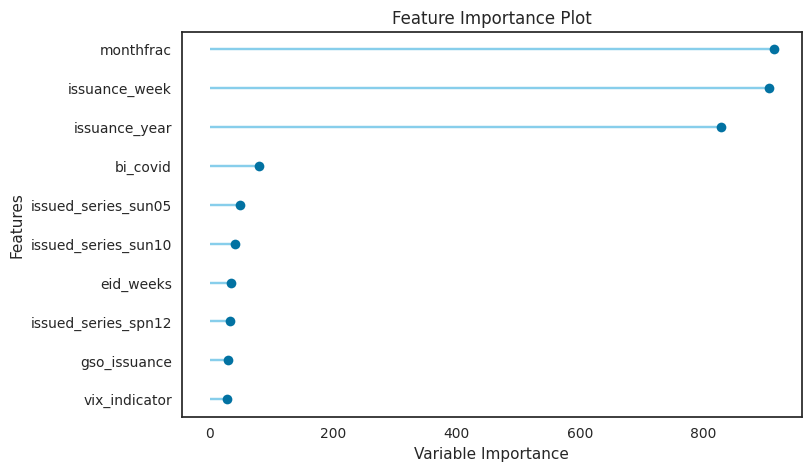

In [23]:
plot_model(create_model('lightgbm'), plot='feature')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2551660.0000,13356545081344.0000,3654660.7500,0.3948,1.2623,0.6915
1,2144280.5000,8634104283136.0000,2938384.7500,0.7187,0.6924,0.6612
2,2506032.7500,15948033556480.0000,3993499.0000,0.6555,1.3173,0.6154
3,2527745.5000,14968136138752.0000,3868867.5000,0.6668,2.0610,0.9595
4,2200868.7500,9088653066240.0000,3014739.2500,0.7135,1.2445,0.9254
5,2489132.0000,14694484017152.0000,3833338.5000,0.6834,1.6831,2.1976
6,2180407.7500,10450651578368.0000,3232746.7500,0.5796,1.2643,1.2910
7,2599065.0000,16614550405120.0000,4076095.0000,0.5191,0.6322,0.6333
8,2433272.5000,11565618167808.0000,3400826.0000,0.6395,0.5619,0.5858


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

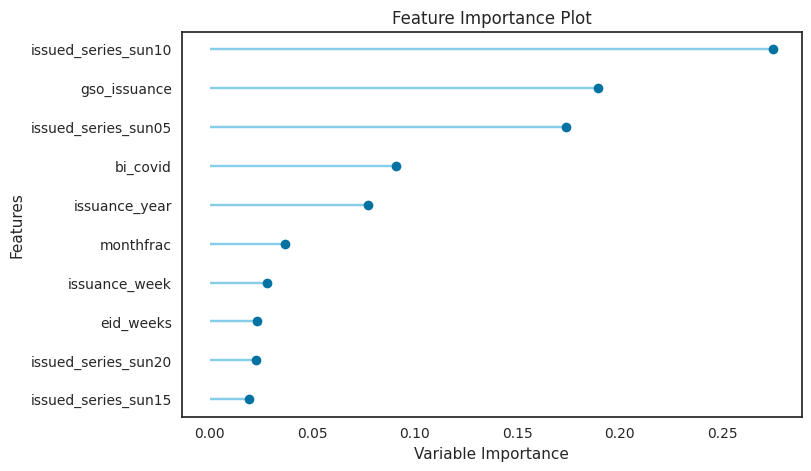

In [24]:
plot_model(create_model('xgboost'), plot='feature')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2098288.2367,9878724421423.1855,3143043.8147,0.5524,1.1520,0.5971
1,2206039.8935,10190743730747.8809,3192294.4305,0.6680,0.7847,0.6860
2,2635366.3787,17355510048770.8984,4165994.4850,0.6251,1.0419,0.6649
3,2351465.0710,12665496349008.1504,3558861.6648,0.7181,1.7334,0.7322
4,2225426.1953,10827065430226.4082,3290450.6424,0.6587,1.2446,0.8510
5,2221687.4201,12346103711081.3574,3513702.2798,0.7340,1.6727,0.9514
6,1986233.1598,7708784791395.5859,2776469.8434,0.6899,1.1403,1.8766
7,2720844.6657,18558701685641.2500,4307981.1612,0.4628,0.5910,0.5542
8,2512206.9704,12276782192152.1562,3503823.9385,0.6173,0.5648,0.5468


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

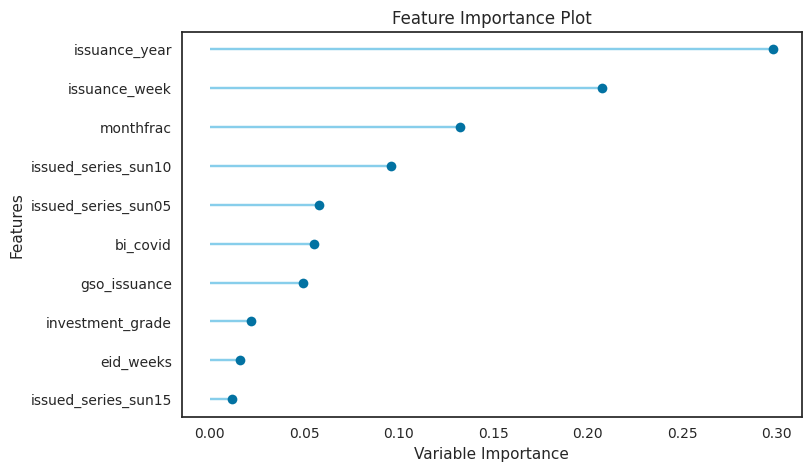

In [25]:
plot_model(create_model('et'), plot='feature')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2317405.1183,10598977221718.2480,3255607.0435,0.5198,1.2544,0.7240
1,2161116.7937,8735879602234.8945,2955652.1450,0.7154,0.6454,0.7361
2,2567804.6154,16077965538341.7637,4009733.8488,0.6527,1.2236,0.7071
3,2401955.5497,14040008563928.2285,3746999.9418,0.6875,2.0069,0.9479
4,2193178.8257,9434438213492.9863,3071553.0621,0.7026,1.3147,0.9417
5,2549230.7638,15227181395385.7637,3902202.1213,0.6720,1.7916,2.8126
6,2184245.5516,9672169941545.7168,3110011.2446,0.6109,1.2780,1.3868
7,2713648.6420,17202935906623.8457,4147642.2105,0.5020,0.6186,0.6410
8,2537072.2750,12054228034227.6270,3471919.9349,0.6243,0.5929,0.6116


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

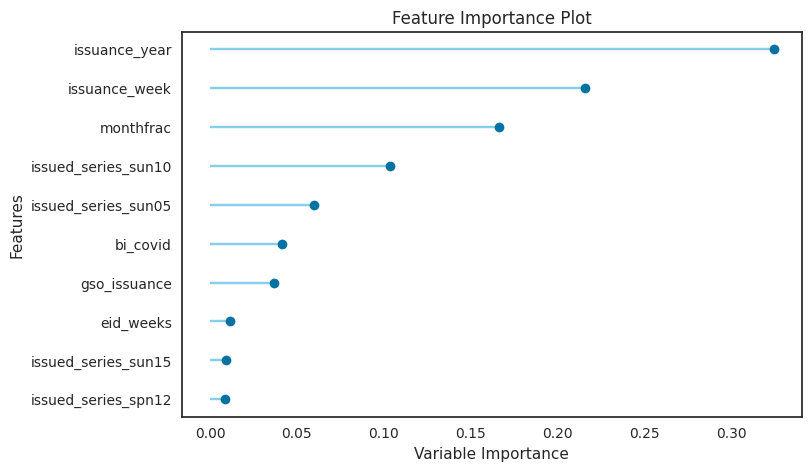

In [26]:
plot_model(create_model('rf'), plot='feature')

# Algorithms

## Light Gradient Boosting Machine

### Raw -- 63.38%

In [27]:
# train a xgb model with default params
lightgbm_raw = create_model('lightgbm')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2459496.3418,11398657091311.2656,3376189.7298,0.4836,1.2318,0.7135
1,2214544.0219,8801675162437.2285,2966761.7300,0.7133,0.6548,0.7674
2,2534608.1000,16200234893926.6855,4024951.5393,0.6501,1.3085,0.5510
3,2745192.5782,17481639582161.0820,4181105.0671,0.6108,1.9930,1.1170
4,2159302.5592,8927352499717.6289,2987867.5506,0.7186,1.3117,0.8729
5,2612514.2380,15640678621511.5684,3954829.7841,0.6631,1.6133,1.6182
6,2135075.1926,8721680266947.5986,2953249.1034,0.6491,1.3188,2.5148
7,2629789.2094,17300171914464.0215,4159347.5347,0.4992,0.6101,0.6768
8,2485452.5021,11158470095637.7129,3340429.6274,0.6522,0.6111,0.6374


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

### Tuning -- 57.65%

In [28]:
# tune hyperparameters of lightgbm
lightgbm_tuned = tune_model(lightgbm_raw)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2635469.0811,13435714227109.8730,3665475.9892,0.3913,1.2974,0.7755
1,2449274.3675,10627742665952.6621,3260021.8812,0.6538,0.7810,0.8960
2,2636504.4279,16815755294461.8203,4100701.8051,0.6368,1.3145,0.6236
3,2787137.3536,16915034159267.5293,4112789.0973,0.6235,1.9868,0.9577
4,2434920.9756,11401539907115.0352,3376616.6361,0.6406,1.3528,1.0156
5,2608245.3957,16291870304049.3594,4036318.9051,0.6490,1.6654,1.1693
6,2651541.7971,12743913610129.8809,3569861.8475,0.4873,1.4390,2.6387
7,2824434.8399,18733790847791.6055,4328254.9426,0.4577,0.7647,0.7793
8,2827288.8193,15064730481541.0664,3881331.0193,0.5304,0.9104,0.7277


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


### Modifying -- 65.42%

In [29]:

# Define a more comprehensive tuning grid for LightGBM
lightgbm_grid = {
    'learning_rate': [0.001, 0.01, 0.1, 0.2, 0.3, 0.5],
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [3, 5, 7, 9, 11],
    'min_child_weight': [1, 3, 5],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
    'reg_alpha': [0, 0.1, 0.01, 0.001],
    'reg_lambda': [1, 1.5, 2, 3, 4],
    'num_leaves': [15, 31, 63, 127],
    'min_split_gain': [0, 0.1, 0.2, 0.3, 0.4],
    'subsample_freq': [0, 1, 2],
}

# Tune LightGBM model with custom grid and optimize for R2
lightgbm_modified = tune_model(lightgbm_raw, custom_grid=lightgbm_grid, optimize='mse', early_stopping=True, choose_better=True)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2498531.7421,11409354520368.6836,3377773.6041,0.4831,1.3084,0.6846
1,2090903.8306,7985689502689.0547,2825896.2300,0.7398,0.6915,0.7440
2,2486803.8269,14475928319584.2012,3804724.4735,0.6873,1.3115,0.5904
3,2547052.1101,15088388350440.5625,3884377.4727,0.6641,1.9800,0.9239
4,2032779.8489,7743850776612.9922,2782777.5291,0.7559,1.2927,0.8659
5,2425586.9184,13250685460852.7871,3640149.0987,0.7145,1.5514,1.4581
6,2269223.6310,9484497391862.6348,3079691.1196,0.6185,1.4088,2.1188
7,2685786.3954,17149493317577.4375,4141194.6727,0.5036,0.6620,0.6973
8,2392973.3418,10691874003145.6445,3269843.1160,0.6667,0.5957,0.5561


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


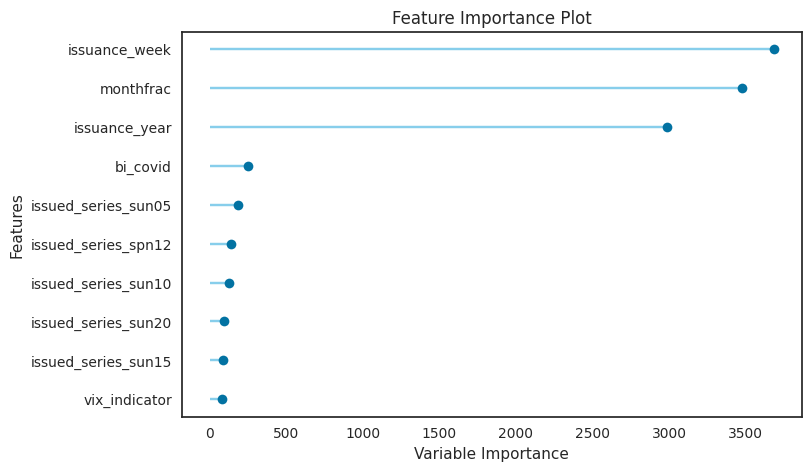

In [30]:
plot_model(lightgbm_modified, plot = 'feature')

### Bagging -- 63.37%

In [31]:
# ensemble with bagging
lightgbm_bagged = ensemble_model(lightgbm_raw, method = 'Bagging')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2404016.4336,10509258461624.7031,3241798.6461,0.5238,1.2841,0.7294
1,2256135.6204,9244475034670.9316,3040472.8308,0.6988,0.7059,0.8297
2,2478885.1681,15124511645929.9707,3889024.5108,0.6733,1.3104,0.5471
3,2735714.8213,17102036045925.3926,4135460.8021,0.6193,1.9792,1.1104
4,2173210.1892,9080790816713.7402,3013435.0527,0.7138,1.3155,0.9175
5,2678785.0495,16361825224984.9434,4044975.3059,0.6475,1.5181,1.7382
6,2176225.6739,8837228689298.5742,2972747.6666,0.6445,1.3158,1.6237
7,2669660.2924,16978930181837.5000,4120549.7427,0.5085,0.6374,0.7428
8,2640445.4613,11855989162912.5527,3443252.7010,0.6305,0.6055,0.6599


Processing:   0%|          | 0/6 [00:00<?, ?it/s]

### Boosting -- 64.63%

In [32]:
# ensemble with boosting
lightgbm_boosted = ensemble_model(lightgbm_raw, method = 'Boosting')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2563820.0292,12176592860272.7402,3489497.5083,0.4483,1.2970,0.7638
1,2286248.6399,9068982324647.5586,3011475.1078,0.7046,0.6993,0.8485
2,2560149.2776,15387592429814.1094,3922702.1847,0.6676,1.3347,0.5888
3,2647067.3498,15081285906797.5430,3883463.1332,0.6643,2.0409,1.0392
4,2231692.8027,8220825446798.2637,2867198.1876,0.7409,1.3313,0.9677
5,2492978.9613,12948860065495.2695,3598452.4542,0.7210,1.6678,1.3551
6,2231215.0991,9228330992718.8984,3037816.8136,0.6288,1.3247,1.5368
7,2673990.3945,16432562917439.0039,4053709.7722,0.5243,0.6253,0.7073
8,2551594.0530,11669853664662.4961,3416116.7522,0.6363,0.5935,0.6490


Processing:   0%|          | 0/6 [00:00<?, ?it/s]

## Extreme Gradient Boosting

### Raw -- 63.12%

In [33]:
# train a xgb model with default params
xgb_raw = create_model('xgboost')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2551660.0000,13356545081344.0000,3654660.7500,0.3948,1.2623,0.6915
1,2144280.5000,8634104283136.0000,2938384.7500,0.7187,0.6924,0.6612
2,2506032.7500,15948033556480.0000,3993499.0000,0.6555,1.3173,0.6154
3,2527745.5000,14968136138752.0000,3868867.5000,0.6668,2.0610,0.9595
4,2200868.7500,9088653066240.0000,3014739.2500,0.7135,1.2445,0.9254
5,2489132.0000,14694484017152.0000,3833338.5000,0.6834,1.6831,2.1976
6,2180407.7500,10450651578368.0000,3232746.7500,0.5796,1.2643,1.2910
7,2599065.0000,16614550405120.0000,4076095.0000,0.5191,0.6322,0.6333
8,2433272.5000,11565618167808.0000,3400826.0000,0.6395,0.5619,0.5858


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

### Tuning -- 65.02%

In [34]:
# tune hyperparameters of xgb
xgb_tuned = tune_model(xgb_raw)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2530011.7500,12537563185152.0000,3540842.2500,0.4320,1.2542,0.6888
1,2228766.7500,8545914322944.0000,2923339.5000,0.7216,0.6277,0.7339
2,2564381.5000,15579695022080.0000,3947112.2500,0.6635,1.3267,0.6985
3,2565248.5000,14241142669312.0000,3773743.7500,0.6830,1.9654,0.8693
4,2123392.2500,8703730778112.0000,2950208.5000,0.7257,1.3196,0.8968
5,2353872.2500,12314803699712.0000,3509245.5000,0.7347,1.6689,1.7428
6,2234322.2500,10410970316800.0000,3226603.5000,0.5812,1.2952,0.7991
7,2496823.0000,15065528926208.0000,3881434.0000,0.5639,0.6721,0.6561
8,2384664.2500,10939342520320.0000,3307467.7500,0.6590,0.7379,0.5755


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


### Modifying -- 65.58%

In [35]:
# define a more comprehensive tuning grid for XGBoost
xgb_grid = {
    'learning_rate': [0.001, 0.01, 0.1, 0.2, 0.3, 0.5],
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [3, 5, 7, 9, 11],
    'min_child_weight': [1, 3, 5],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
    'gamma': [0, 0.1, 0.2, 0.3, 0.4],
    'reg_alpha': [0, 0.1, 0.01, 0.001],
    'reg_lambda': [1, 1.5, 2, 3, 4]
}

# tune model with custom grid and optimize for R2
xgb_modified = tune_model(xgb_raw, custom_grid=xgb_grid, optimize='mse', early_stopping=True, choose_better=True)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2404710.7500,10266490175488.0000,3204136.5000,0.5348,1.1993,0.6726
1,2136589.7500,8655833923584.0000,2942079.7500,0.7180,0.6642,0.7022
2,2473824.2500,14448016228352.0000,3801054.5000,0.6879,1.2977,0.5759
3,2584284.5000,15534893563904.0000,3941433.0000,0.6542,1.9810,0.9267
4,2131596.0000,8680273608704.0000,2946230.5000,0.7264,1.2878,0.8856
5,2454191.2500,13632620462080.0000,3692237.7500,0.7063,1.7536,2.2249
6,2179763.7500,9139485933568.0000,3023158.2500,0.6323,1.2913,1.5644
7,2572157.2500,16009204334592.0000,4001150.5000,0.5366,0.6743,0.6807
8,2430829.0000,10807743086592.0000,3287513.2500,0.6631,0.6551,0.5728


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


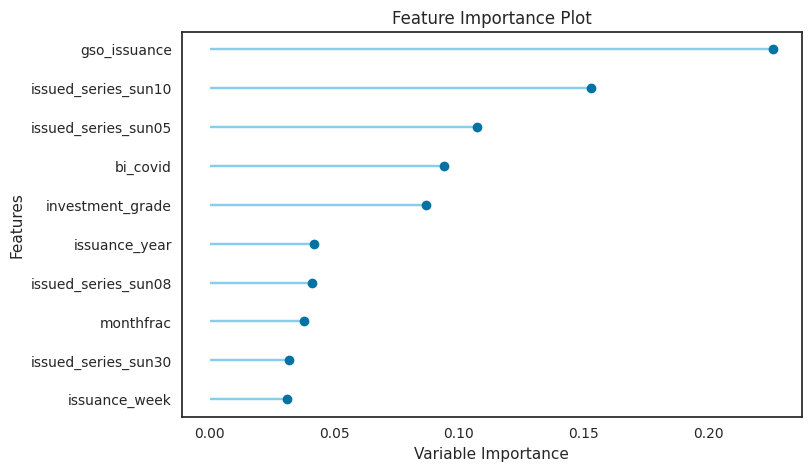

In [36]:
plot_model(xgb_modified, plot = 'feature')

### Bagging -- 64.41%

In [37]:
# ensemble with bagging
xgb_bagged = ensemble_model(xgb_raw, method = 'Bagging')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2395797.5000,11060442562560.0000,3325724.2500,0.4989,1.2344,0.6804
1,2153074.0000,8655363637248.0000,2942000.0000,0.7180,0.6254,0.7170
2,2440591.5000,15059991396352.0000,3880720.5000,0.6747,1.2884,0.5836
3,2481761.0000,14688460996608.0000,3832552.7500,0.6730,1.9434,1.0059
4,2117516.2500,8590995750912.0000,2931040.0000,0.7292,1.2659,0.8947
5,2508072.5000,15546424754176.0000,3942895.5000,0.6651,1.7017,2.0690
6,2138400.0000,9184359743488.0000,3030570.7500,0.6305,1.2913,1.5271
7,2589649.5000,16132183425024.0000,4016489.0000,0.5330,0.6206,0.6640
8,2461123.0000,11310873968640.0000,3363164.2500,0.6474,0.5901,0.6054


Processing:   0%|          | 0/6 [00:00<?, ?it/s]

### Boosting -- 64.43%

In [38]:
# ensemble with boosting
xgb_boosted = ensemble_model(xgb_raw, method = 'Boosting')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2510098.2500,12443002601472.0000,3527464.0000,0.4362,1.2492,0.6921
1,2163301.5000,8475109228544.0000,2911204.0000,0.7239,0.6345,0.7401
2,2481587.2500,15563819581440.0000,3945100.7500,0.6638,1.3420,0.6319
3,2395925.5000,13814364897280.0000,3716768.0000,0.6925,1.9856,0.9443
4,2190266.7500,9269483143168.0000,3044582.5000,0.7078,1.2435,0.9008
5,2307030.2500,12777956573184.0000,3574626.7500,0.7247,1.6323,1.1722
6,2090948.1250,9065718611968.0000,3010933.2500,0.6353,1.2751,1.2332
7,2646072.5000,16888251809792.0000,4109531.7500,0.5111,0.6414,0.6773
8,2462555.0000,11499913347072.0000,3391152.2500,0.6416,0.5968,0.6189


Processing:   0%|          | 0/6 [00:00<?, ?it/s]

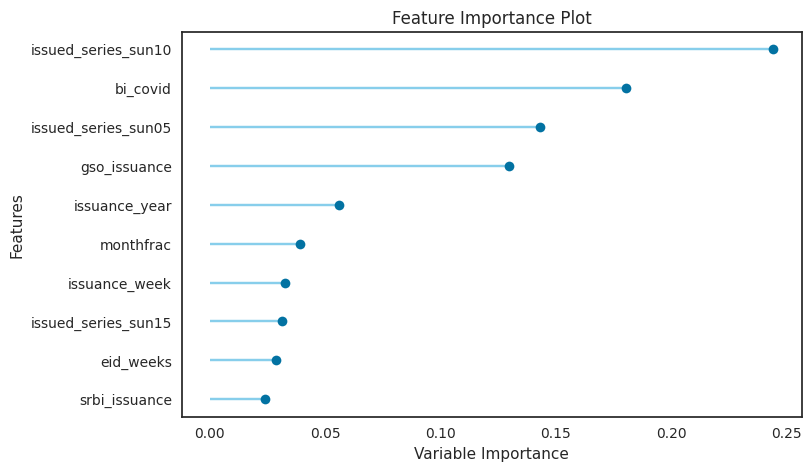

In [39]:
plot_model(xgb_boosted, plot = 'feature')

## Extra Trees Regressor

### Raw -- 64.57%

In [40]:
# train a et model with default params
et_raw = create_model('et')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2098288.2367,9878724421423.1855,3143043.8147,0.5524,1.1520,0.5971
1,2206039.8935,10190743730747.8809,3192294.4305,0.6680,0.7847,0.6860
2,2635366.3787,17355510048770.8984,4165994.4850,0.6251,1.0419,0.6649
3,2351465.0710,12665496349008.1504,3558861.6648,0.7181,1.7334,0.7322
4,2225426.1953,10827065430226.4082,3290450.6424,0.6587,1.2446,0.8510
5,2221687.4201,12346103711081.3574,3513702.2798,0.7340,1.6727,0.9514
6,1986233.1598,7708784791395.5859,2776469.8434,0.6899,1.1403,1.8766
7,2720844.6657,18558701685641.2500,4307981.1612,0.4628,0.5910,0.5542
8,2512206.9704,12276782192152.1562,3503823.9385,0.6173,0.5648,0.5468


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

### Tuning -- 55.36%

In [41]:
# tune hyperparameters of et
et_tuned = tune_model(et_raw)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2336212.8097,9951650429511.8750,3154623.6589,0.5491,1.3411,0.8810
1,2687359.0418,13245012494222.3887,3639369.7936,0.5685,0.7785,1.0943
2,2747074.6678,16733357200415.3984,4090642.6391,0.6386,1.3248,0.8871
3,2969698.4983,20432112429600.7852,4520189.4241,0.5452,2.1394,1.2839
4,2552298.1622,13817631215752.9824,3717207.4486,0.5645,1.4265,1.0977
5,2967788.8889,20466543871842.4219,4523996.4491,0.5591,1.8611,2.7282
6,2452537.5412,11053537230471.7051,3324686.0349,0.5553,1.4457,4.3488
7,3031422.5876,20728099328277.7734,4552812.2439,0.4000,0.6761,0.8011
8,2849376.1057,14072952445888.5859,3751393.4006,0.5614,0.6928,0.8364


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


### Modifying -- 60.93%

In [42]:
# define a more comprehensive tuning grid for Random Forest Regressor
et_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [None, 4, 8, 12],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['auto', 'sqrt', None],
    'bootstrap': [True, False]
}

# Tune model with the optimized grid and optimize for Mean Squared Error (mse)
et_modified = tune_model(et_raw, custom_grid=et_grid, optimize='mse', early_stopping=True, choose_better=True)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2221580.9780,9225290057018.8086,3037316.2590,0.5820,1.2892,0.7862
1,2335976.7563,10394453450607.0312,3224043.0287,0.6614,0.7001,0.9001
2,2546151.7625,15433469730169.4043,3928545.4980,0.6666,1.2714,0.7519
3,2664477.3913,16709830455374.6055,4087765.9492,0.6280,2.0255,1.1779
4,2379197.0876,11956384307133.6504,3457800.5013,0.6231,1.3552,1.1002
5,2785324.2358,18508803873420.7383,4302185.9413,0.6013,1.8022,2.6903
6,2277737.1245,9479890831246.0918,3078943.1354,0.6186,1.3831,2.4940
7,2795718.3120,18472098127834.2383,4297917.8829,0.4653,0.6307,0.6941
8,2635595.2866,12560122638681.6641,3544026.3315,0.6085,0.6334,0.6961


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


### Bagging -- 65.00%

In [43]:
# ensemble with bagging
et_bagged = ensemble_model(et_raw, method = 'Bagging')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2083000.8355,8467665450868.0078,2909925.3342,0.6163,1.1950,0.6382
1,2152013.4225,9648845708634.5586,3106259.1181,0.6857,0.6987,0.7163
2,2570099.0213,16348773550051.9062,4043361.6645,0.6469,1.2177,0.6944
3,2430235.7021,14355280774875.6797,3788836.3352,0.6804,1.8644,0.9476
4,2257446.2436,11196380875848.1309,3346099.3524,0.6471,1.2576,0.9253
5,2358931.0223,14389869399471.6504,3793398.1335,0.6900,1.7235,2.0114
6,2051410.5276,8157079649356.0596,2856060.1621,0.6719,1.2378,1.6835
7,2685640.9007,16901870723043.7480,4111188.4806,0.5107,0.6032,0.5932
8,2556615.4592,11890242168113.5098,3448223.0450,0.6294,0.5841,0.5959


Processing:   0%|          | 0/6 [00:00<?, ?it/s]

### Boosting -- 64.20%

In [44]:
# ensemble with boosting
et_boosted = ensemble_model(et_raw, method = 'Boosting')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2283637.8181,11891188900270.4121,3448360.3205,0.4612,1.1577,0.6661
1,2124678.8141,9720768666627.9590,3117814.7262,0.6833,0.6066,0.6659
2,2605979.7234,16377954621167.9609,4046968.5718,0.6462,1.1122,0.6882
3,2450928.7456,13878796308916.4258,3725425.6547,0.6910,1.9383,0.8431
4,2262360.7566,10198653731068.9297,3193533.1110,0.6785,1.3016,0.9766
5,2328756.2666,12999374928671.5156,3605464.5926,0.7200,1.6857,1.5741
6,2048639.3207,7933505137927.3311,2816647.8548,0.6808,1.3196,1.8085
7,2656125.9080,17749418112662.3867,4213005.8287,0.4862,0.6013,0.6044
8,2494282.1469,11381178286493.3789,3373600.1966,0.6453,0.5622,0.5646


Processing:   0%|          | 0/6 [00:00<?, ?it/s]

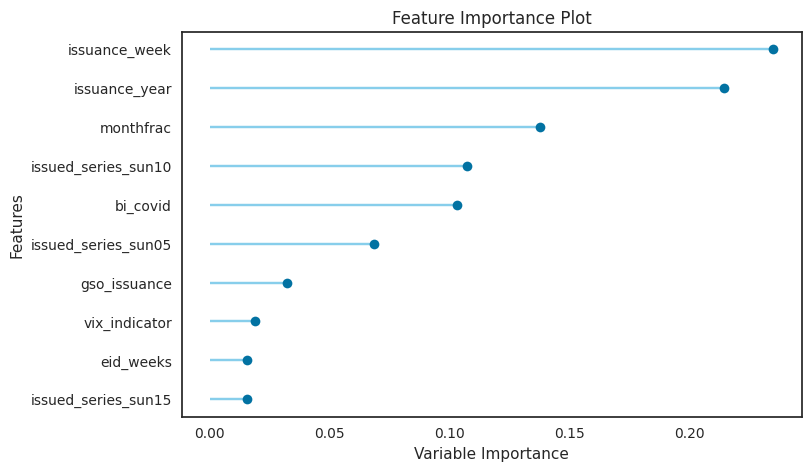

In [ ]:
plot_model(et_boosted, plot = 'feature')

## Random Forest Regressor

### Raw -- 63.52%

In [45]:
# train a rf model with default params
rf_raw = create_model('rf')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2317405.1183,10598977221718.2480,3255607.0435,0.5198,1.2544,0.7240
1,2161116.7937,8735879602234.8945,2955652.1450,0.7154,0.6454,0.7361
2,2567804.6154,16077965538341.7637,4009733.8488,0.6527,1.2236,0.7071
3,2401955.5497,14040008563928.2285,3746999.9418,0.6875,2.0069,0.9479
4,2193178.8257,9434438213492.9863,3071553.0621,0.7026,1.3147,0.9417
5,2549230.7638,15227181395385.7637,3902202.1213,0.6720,1.7916,2.8126
6,2184245.5516,9672169941545.7168,3110011.2446,0.6109,1.2780,1.3868
7,2713648.6420,17202935906623.8457,4147642.2105,0.5020,0.6186,0.6410
8,2537072.2750,12054228034227.6270,3471919.9349,0.6243,0.5929,0.6116


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

### Tuning -- 57.21%

In [46]:
# tune hyperparameters of rf
rf_tuned = tune_model(rf_raw)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2430269.1048,10592065738586.9902,3254545.3966,0.5201,1.3566,0.8476
1,2564945.1317,12056933277114.5449,3472309.5019,0.6072,0.7609,1.0411
2,2714782.3746,17094959237095.3633,4134605.0884,0.6307,1.3596,0.8501
3,2786541.6729,18862274799199.8711,4343072.0463,0.5801,2.1183,1.1609
4,2331290.2061,10636185383893.1367,3261316.5108,0.6648,1.4074,1.0156
5,2965531.4923,20221164515841.8594,4496794.9159,0.5644,1.8764,3.7015
6,2362849.2448,10830335365619.5527,3290947.4875,0.5643,1.4066,3.0779
7,2837875.4771,19206658792718.9531,4382540.2215,0.4440,0.6606,0.7694
8,2792525.5099,14050920834440.8164,3748455.7933,0.5620,0.6721,0.7657


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


### Modifying -- 62.99%

In [47]:
# define a more comprehensive tuning grid for Random Forest Regressor
rf_grid = {
    'n_estimators': [50, 100, 150, 200],
    'max_depth': [None, 4, 8, 12, 16],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2', None],
    'bootstrap': [True, False]
}

# Tune model with the optimized grid and optimize for Mean Squared Error (mse)
rf_modified = tune_model(rf_raw, custom_grid=rf_grid, optimize='mse', early_stopping=True, choose_better=True)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2336364.4156,10070698744763.1055,3173436.4252,0.5437,1.2777,0.7502
1,2222339.9331,9083211245914.7500,3013836.6323,0.7041,0.6666,0.7854
2,2620867.0998,16243899665861.1641,4030372.1498,0.6491,1.2606,0.7435
3,2496248.4441,15131739568576.8164,3889953.6718,0.6632,2.0285,1.0109
4,2186184.1148,9441491652784.4629,3072701.0354,0.7024,1.3450,0.9748
5,2619739.6617,16194434796414.6562,4024230.9571,0.6511,1.7996,3.2701
6,2165171.6821,9241622559103.6621,3040003.7104,0.6282,1.2941,1.3645
7,2733898.3881,17249589913705.3945,4153262.5626,0.5007,0.6176,0.6436
8,2545665.2212,12219692981452.5625,3495667.7447,0.6191,0.6085,0.6466


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


### Bagging -- 61.83%

In [48]:
# ensemble with bagging
rf_bagged = ensemble_model(rf_raw, method = 'Bagging')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2286094.8575,9377810589878.7344,3062321.1115,0.5751,1.2893,0.7604
1,2426889.3647,10585400448177.6504,3253521.2383,0.6552,0.7104,0.8943
2,2651463.6768,16827580837401.7148,4102143.4443,0.6365,1.2815,0.7585
3,2602583.7779,15557366106571.0117,3944282.7113,0.6537,2.0263,1.1108
4,2265561.2481,9798854061389.4648,3130312.1348,0.6911,1.3623,1.0317
5,2749256.3036,18236169156347.5195,4270382.7880,0.6071,1.8163,3.3593
6,2168012.4006,9213920870189.0859,3035444.0977,0.6293,1.3563,2.0679
7,2717468.2945,17068995482335.5781,4131464.0846,0.5059,0.6289,0.7016
8,2609346.5529,12395412875120.7773,3520711.9841,0.6136,0.6169,0.6704


Processing:   0%|          | 0/6 [00:00<?, ?it/s]

### Boosting -- 65.38%

In [49]:
# ensemble with boosting
rf_boosted = ensemble_model(rf_raw, method = 'Boosting')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2382264.9644,10005039520590.1855,3163074.3780,0.5467,1.2583,0.7553
1,2215873.5842,8993392617403.8301,2998898.5674,0.7070,0.6826,0.8363
2,2488439.1109,14325623562553.3145,3784920.5490,0.6906,1.2368,0.7426
3,2388864.4520,12719887940606.1855,3566495.1900,0.7168,2.0094,0.9648
4,2252862.4150,10199776469404.0801,3193708.8893,0.6785,1.3261,1.0181
5,2457236.4883,12918315842602.6250,3594205.8709,0.7217,1.7632,1.9197
6,2133011.1806,8174978985186.7393,2859192.0161,0.6711,1.3208,1.6143
7,2778928.4013,18508962168515.0391,4302204.3383,0.4642,0.6287,0.7094
8,2460372.0245,10895863832828.3613,3300888.3400,0.6604,0.5805,0.6206


Processing:   0%|          | 0/6 [00:00<?, ?it/s]

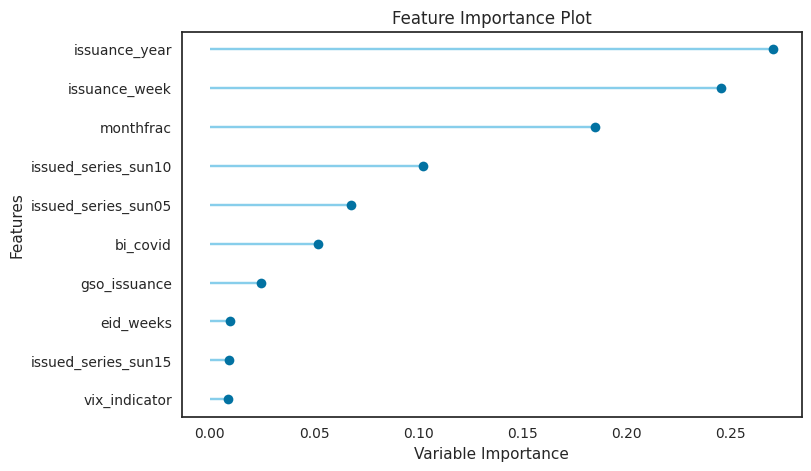

In [50]:
plot_model(rf_boosted, plot = 'feature')

# Choosen

## Blended -- 68.01%

In [51]:
# Blend the Boosted Ensembles
blended = blend_models(estimator_list=[lightgbm_modified, xgb_modified, et_bagged, rf_boosted], fold=10)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2251915.5096,9291200644735.7129,3048147.0838,0.5790,1.2128,0.6522
1,2039430.0531,7971511237395.5645,2823386.4839,0.7403,0.6355,0.6896
2,2387667.0354,13861988574999.0684,3723169.1575,0.7006,1.2658,0.6179
3,2370190.3814,13567946387595.3965,3683469.3412,0.6980,1.8605,0.9104
4,2055191.8575,8387693355054.1084,2896151.4731,0.7356,1.2693,0.8328
5,2328817.0260,12795951885940.2539,3577142.9781,0.7243,1.6827,1.8491
6,2051696.5148,7787699735118.9746,2790645.0393,0.6867,1.1498,1.1312
7,2582782.5955,16210566682579.4121,4026234.8022,0.5308,0.5991,0.6410
8,2365038.7653,10235897785677.4551,3199358.9648,0.6810,0.5583,0.5567


Processing:   0%|          | 0/6 [00:00<?, ?it/s]

In [52]:
predict_model(blended);

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Voting Regressor,2414266.0497,13177858872540.3359,3630132.0737,0.5743,0.5931,0.6108


In [ ]:
# plot_model(blended, plot = 'residuals')

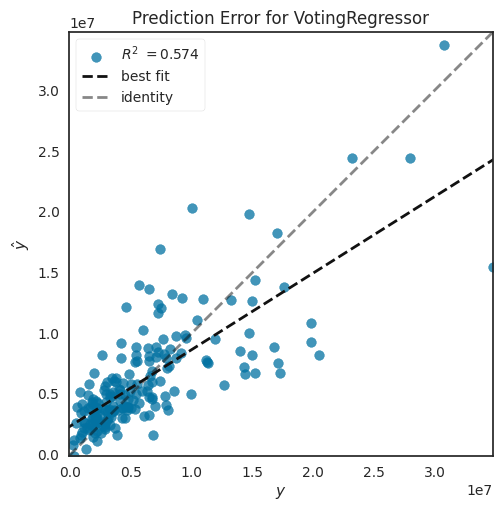

In [53]:
plot_model(blended, plot = 'error')

## Stacked -- 68.02%

In [54]:
stacked = stack_models(estimator_list=[lightgbm_modified, xgb_tuned, et_bagged, rf_boosted])

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2271515.9216,9922688579537.8633,3150029.9331,0.5504,1.1142,0.6051
1,2021996.7857,7637987958578.2959,2763691.0027,0.7512,0.5704,0.6255
2,2389626.1837,14608499945292.6523,3822106.7417,0.6845,1.2404,0.5741
3,2395843.2139,13671826798566.0938,3697543.3464,0.6957,1.9040,0.8774
4,1962152.6027,8075556478011.2451,2841752.3604,0.7455,1.2541,0.8086
5,2246622.4380,12604014365837.0820,3550213.2846,0.7285,1.6641,1.7096
6,2048151.0027,7902449868133.6797,2811129.6427,0.6821,1.2347,0.9524
7,2499060.8463,15535419327671.6387,3941499.6293,0.5503,0.5811,0.5926
8,2354167.6971,10269753167322.9668,3204645.5603,0.6799,0.5549,0.5488


Processing:   0%|          | 0/6 [00:00<?, ?it/s]

In [55]:
predict_model(stacked);

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Stacking Regressor,2359960.5809,12895689013101.9395,3591056.8101,0.5835,0.5803,0.5791


In [ ]:
# plot_model(stacked, plot = 'residuals')

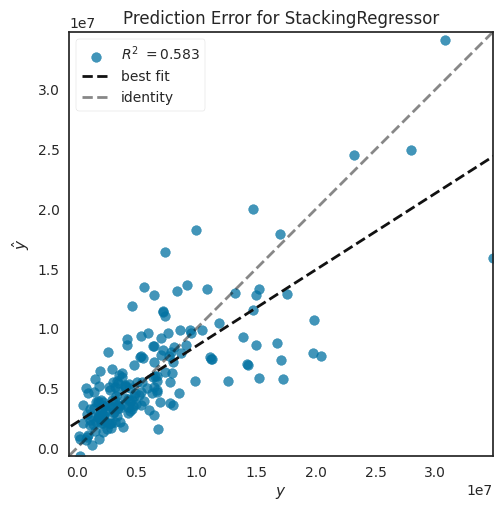

In [56]:
plot_model(stacked, plot = 'error')

## Finalizing -- 95.19%

In [57]:
final = finalize_model(stacked)
predict_model(final);

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Stacking Regressor,836677.8887,1489921563550.5103,1220623.4323,0.9519,0.2720,0.2143


In [64]:
final02 = finalize_model(blended)
predict_model(final02);

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Voting Regressor,1093314.7320,2474497560558.4429,1573053.5784,0.9201,0.3213,0.2896


In [58]:
save_model(final, '/content/drive/MyDrive/00database/20240625_stacked01')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('numerical_imputer',
                  TransformerWrapper(include=['issuance_year', 'issuance_week',
                                              'monthfrac', 'eid_weeks',
                                              'srbi_issuance', 'vix_indicator',
                                              'bi_covid', 'gso_issuance',
                                              'investment_grade'],
                                     transformer=SimpleImputer())),
                 ('categorical_imputer',
                  TransformerWrapper(include=['issued_series'],
                                     transformer=SimpleImpute...
                                                              num_parallel_tree=None,
                                                              random_state=123, ...)),
                                                ('Extra Trees Regressor',
                                                 BaggingRegress

In [65]:
save_model(final02, '/content/drive/MyDrive/00database/20240625_blended01')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('numerical_imputer',
                  TransformerWrapper(include=['issuance_year', 'issuance_week',
                                              'monthfrac', 'eid_weeks',
                                              'srbi_issuance', 'vix_indicator',
                                              'bi_covid', 'gso_issuance',
                                              'investment_grade'],
                                     transformer=SimpleImputer())),
                 ('categorical_imputer',
                  TransformerWrapper(include=['issued_series'],
                                     transformer=SimpleImpute...
                                                            multi_strategy=None,
                                                            n_estimators=100,
                                                            n_jobs=-1,
                                                            num_parallel_tree=No

# Lelang 25 Juni 2024

## Load

In [59]:
lelang20240625 = pd.read_excel('/content/drive/MyDrive/00database/db_monthfrac.xlsx', sheet_name='lelang20240625')
lelang20240625['issuance_date'] = pd.to_datetime(lelang20240625['issuance_date'], format='%Y-%m-%d')
lelang20240625.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7 entries, 0 to 6
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   issued_series     7 non-null      object        
 1   issuance_date     7 non-null      datetime64[ns]
 2   issuance_year     7 non-null      int64         
 3   issuance_week     7 non-null      int64         
 4   monthfrac         7 non-null      int64         
 5   eid_weeks         7 non-null      int64         
 6   srbi_issuance     7 non-null      int64         
 7   vix_indicator     7 non-null      int64         
 8   bi_covid          7 non-null      int64         
 9   gso_issuance      7 non-null      int64         
 10  investment_grade  7 non-null      int64         
dtypes: datetime64[ns](1), int64(9), object(1)
memory usage: 744.0+ bytes


## Predict: Stacked

In [60]:
# load model
stacked01_20240625 = load_model("/content/drive/MyDrive/00database/20240625_stacked01")

# predict model on new_data
predict03= predict_model(stacked01_20240625, data = lelang20240625)
predict03

# predict model on new_data
# predict03= predict_model(final, data = lelang20240625)
# predict03

Transformation Pipeline and Model Successfully Loaded


,issued_series,issuance_date,issuance_year,issuance_week,monthfrac,eid_weeks,srbi_issuance,vix_indicator,bi_covid,gso_issuance,investment_grade,prediction_label
0,spn03,2024-06-25,2024,26,3,0,1,0,0,0,1,7.697714e+05
1,spn12,2024-06-25,2024,26,11,0,1,0,0,0,1,2.760606e+06
2,sun05,2024-06-25,2024,26,57,0,1,0,0,0,1,1.010937e+07
3,sun10,2024-06-25,2024,26,115,0,1,0,0,0,1,9.886417e+06
4,sun15,2024-06-25,2024,26,167,0,1,0,0,0,1,3.684138e+06
5,sun20,2024-06-25,2024,26,227,0,1,0,0,0,1,4.757569e+06
6,sun30,2024-06-25,2024,26,360,0,1,0,0,0,1,1.696635e+06


In [68]:
# @title Lelang 20240625: Per series

# !pip install --upgrade pip
# !pip install tabulate

import tabulate

# Incoming bid per series
predict04 = predict03[['issued_series', 'issuance_date', 'prediction_label']]

# Create a new column with formatted dates
predict04['issuance_date'] = predict04['issuance_date'].dt.strftime('%Y-%m-%d')

# Format the 'prediction_label' column
predict04['prediction_label'] = predict04['prediction_label'].apply(lambda x: '{:,.2f} trillion'.format(x / 1_000_000))

# Convert the DataFrame to a list of dictionaries for tabulate
table_data = predict04.to_dict(orient='records')

# Specify the column alignments
column_alignments = {'issued_series': 'left', 'issuance_date': 'center', 'prediction_label': 'right'}

# Display the formatted DataFrame using tabulate
formatted_table = tabulate.tabulate(table_data, headers="keys", floatfmt=".2f", showindex=False, colalign=list(column_alignments.values()), tablefmt="pipe")

print(formatted_table)

| issued_series   |  issuance_date  |   prediction_label |
|:----------------|:---------------:|-------------------:|
| spn03           |   2024-06-25    |      0.77 trillion |
| spn12           |   2024-06-25    |      2.76 trillion |
| sun05           |   2024-06-25    |     10.11 trillion |
| sun10           |   2024-06-25    |      9.89 trillion |
| sun15           |   2024-06-25    |      3.68 trillion |
| sun20           |   2024-06-25    |      4.76 trillion |
| sun30           |   2024-06-25    |      1.70 trillion |


In [71]:
# @title Lelang 20240625: Total

# Sum total incoming bid
incoming_bid = predict03['prediction_label'].sum()

# Round to two decimal places
rounded_bid = round(incoming_bid, 2)
formatted_rounded_bid = 'Rp{:,.2f} million'.format(rounded_bid)

# Adjust to the nearest thousand
formatted_incoming_bid = 'Rp{:,.2f} trillion'.format(rounded_bid / 1000000)

output_message = f"""
According to a stacked machine learning algorithm model with an R-squared value of 68.02%,
the estimated incoming bid for the next issuance is approximately {formatted_rounded_bid}
or {formatted_incoming_bid}.
"""

print(output_message)



According to a stacked machine learning algorithm model with an R-squared value of 68.02%,
the estimated incoming bid for the next issuance is approximately Rp33,664,502.86 million
or Rp33.66 trillion.



## Predict: Blended

In [67]:
# load model
blended01_20240625 = load_model("/content/drive/MyDrive/00database/20240625_blended01")

# predict model on new_data
predict05 = predict_model(blended01_20240625, data = lelang20240625)
predict05

# predict model on new_data
# predict04= predict_model(final, data = lelang20240625)
# predict04

Transformation Pipeline and Model Successfully Loaded


,issued_series,issuance_date,issuance_year,issuance_week,monthfrac,eid_weeks,srbi_issuance,vix_indicator,bi_covid,gso_issuance,investment_grade,prediction_label
0,spn03,2024-06-25,2024,26,3,0,1,0,0,0,1,9.526094e+05
1,spn12,2024-06-25,2024,26,11,0,1,0,0,0,1,3.072752e+06
2,sun05,2024-06-25,2024,26,57,0,1,0,0,0,1,1.090407e+07
3,sun10,2024-06-25,2024,26,115,0,1,0,0,0,1,1.153261e+07
4,sun15,2024-06-25,2024,26,167,0,1,0,0,0,1,4.994720e+06
5,sun20,2024-06-25,2024,26,227,0,1,0,0,0,1,4.810553e+06
6,sun30,2024-06-25,2024,26,360,0,1,0,0,0,1,2.379656e+06


In [69]:
# @title Lelang 20240625: Per series

# !pip install --upgrade pip
# !pip install tabulate

import tabulate

# Incoming bid per series
predict06 = predict05[['issued_series', 'issuance_date', 'prediction_label']]

# Create a new column with formatted dates
predict06['issuance_date'] = predict06['issuance_date'].dt.strftime('%Y-%m-%d')

# Format the 'prediction_label' column
predict06['prediction_label'] = predict06['prediction_label'].apply(lambda x: '{:,.2f} trillion'.format(x / 1_000_000))

# Convert the DataFrame to a list of dictionaries for tabulate
table_data = predict06.to_dict(orient='records')

# Specify the column alignments
column_alignments = {'issued_series': 'left', 'issuance_date': 'center', 'prediction_label': 'right'}

# Display the formatted DataFrame using tabulate
formatted_table = tabulate.tabulate(table_data, headers="keys", floatfmt=".2f", showindex=False, colalign=list(column_alignments.values()), tablefmt="pipe")

print(formatted_table)

| issued_series   |  issuance_date  |   prediction_label |
|:----------------|:---------------:|-------------------:|
| spn03           |   2024-06-25    |      0.95 trillion |
| spn12           |   2024-06-25    |      3.07 trillion |
| sun05           |   2024-06-25    |     10.90 trillion |
| sun10           |   2024-06-25    |     11.53 trillion |
| sun15           |   2024-06-25    |      4.99 trillion |
| sun20           |   2024-06-25    |      4.81 trillion |
| sun30           |   2024-06-25    |      2.38 trillion |


In [74]:
# @title Lelang 20240625: Total

# Sum total incoming bid
incoming_bid02 = predict05['prediction_label'].sum()

# Round to two decimal places
rounded_bid02 = round(incoming_bid02, 2)
formatted_rounded_bid02 = 'Rp{:,.2f} million'.format(rounded_bid02)

# Adjust to the nearest thousand
formatted_incoming_bid02 = 'Rp{:,.2f} trillion'.format(rounded_bid02 / 1000000)

output_message02 = f"""
According to a stacked machine learning algorithm model with an R-squared value of 68.01%,
the estimated incoming bid for the next issuance is approximately {formatted_rounded_bid02}
or {formatted_incoming_bid02}.
"""

print(output_message02)



According to a stacked machine learning algorithm model with an R-squared value of 68.01%,
the estimated incoming bid for the next issuance is approximately Rp38,646,971.04 million
or Rp38.65 trillion.

